**Kernel**
- [Intro to Recurrent Neural Networks LSTM | GRU](https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru)

**Dataset**
- [DJIA 30 Stock Time Series](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231/code?datasetId=8388&sortBy=voteCount)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
def plot_predictions(test, predicted):
    plt.plot(test, color='red', label='Real IBM Stock Price')
    plt.plot(predicted, color='blue', label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()
    
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print(f'The root mean squared error is {rmse}')

In [3]:
dataset = pd.read_csv('data/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [4]:
training_set = dataset[:'2016'].iloc[:, 1:2].values
test_set = dataset['2017':].iloc[:, 1:2].values

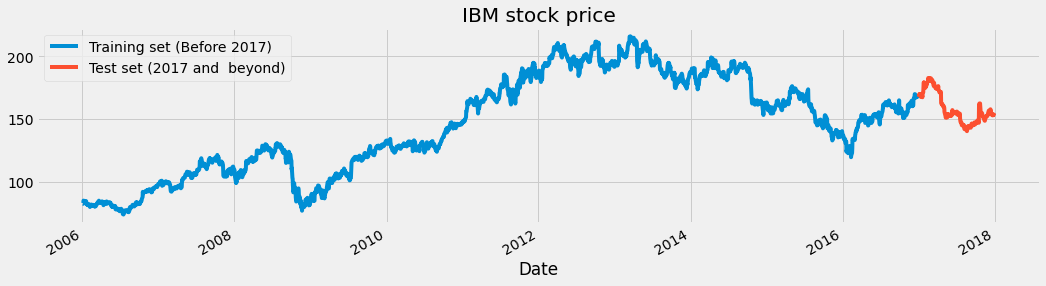

In [5]:
dataset['High'][:'2016'].plot(figsize=(16,4), legend=True)
dataset['High']['2017':].plot(figsize=(16,4), legend=True)
plt.legend(['Training set (Before 2017)', 'Test set (2017 and  beyond)'])
plt.title('IBM stock price')
plt.show()

In [6]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60, 2769):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
X_train.shape

(2709, 60, 1)

In [10]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 25s 130ms/step - loss: 0.0559
Epoch 2/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0112
Epoch 3/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0081
Epoch 4/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0075
Epoch 5/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0059
Epoch 6/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0055
Epoch 7/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0050
Epoch 8/50
85/85 [==============================] - 11s 128ms/step - loss: 0.0045
Epoch 9/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0049
Epoch 10/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0041
Epoch 11/50
85/85 [==============================] - 11s 129ms/step - loss: 0.0035
Epoch 12/50
85/85 [==============================] - 11s 128ms/step - loss: 0.0036
Epoch 13/50
8

In [11]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset['High'][:'2016'], dataset['High']['2017':]), axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [12]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60, 311):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

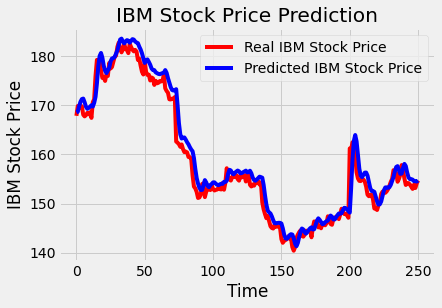

In [13]:
# Visualizing the results for LSTM
plot_predictions(test_set, predicted_stock_price)

In [14]:
# Evaluating our model
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 2.364683674484227


In [15]:
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularization
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# Fitting to the training set
regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)

Epoch 1/50
19/19 [==============================] - 19s 276ms/step - loss: 0.1895
Epoch 2/50
19/19 [==============================] - 5s 270ms/step - loss: 0.0650
Epoch 3/50
19/19 [==============================] - 5s 241ms/step - loss: 0.0285
Epoch 4/50
19/19 [==============================] - 5s 262ms/step - loss: 0.0065
Epoch 5/50
19/19 [==============================] - 5s 247ms/step - loss: 0.0055
Epoch 6/50
19/19 [==============================] - 4s 221ms/step - loss: 0.0045
Epoch 7/50
19/19 [==============================] - 5s 252ms/step - loss: 0.0039
Epoch 8/50
19/19 [==============================] - 5s 272ms/step - loss: 0.0035
Epoch 9/50
19/19 [==============================] - 5s 272ms/step - loss: 0.0038
Epoch 10/50
19/19 [==============================] - 5s 267ms/step - loss: 0.0033
Epoch 11/50
19/19 [==============================] - 5s 260ms/step - loss: 0.0032
Epoch 12/50
19/19 [==============================] - 5s 273ms/step - loss: 0.0032
Epoch 13/50
19/19 [=====

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [16]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60, 311):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

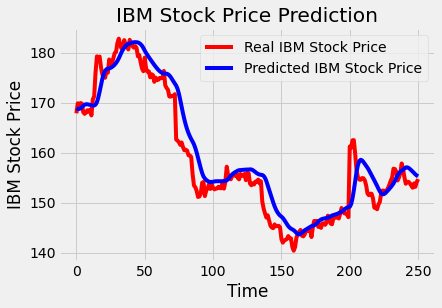

In [21]:
# Visualizing the results for GRU
plot_predictions(test_set, GRU_predicted_stock_price)

In [22]:
# Evaluating GRU
return_rmse(test_set, GRU_predicted_stock_price)

The root mean squared error is 3.5312431969334512


In [40]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

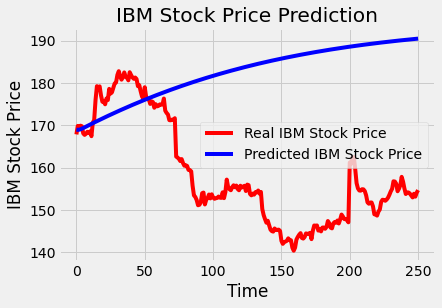

In [41]:
# Visualizing the sequence
plot_predictions(test_set, sequence)

In [42]:
# Evaluating the sequence
return_rmse(test_set, sequence)

The root mean squared error is 29.727995669226875
